In [10]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil

import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetrForObjectDetection
from transformers import DetrConfig, DetrImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [3]:


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))



The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 39
Number of validation examples: 6


In [4]:
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.save_hyperparameters()
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [3]:
# Training




# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETR",
            "dataset": "test_minimal_set",
            "train_set_size": len(train_dataset)}
    )

model = Detr(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
print(outputs.logits.shape)

wandb_logger = WandbLogger(project=project, log_model=True)
trainer = Trainer(max_steps=300, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([4, 100, 11])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.


In [5]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/model-58vqddbm:v0', type='model')
artifact_dir = artifact.download()

model = Detr.load_from_checkpoint(artifact_dir + "/model.ckpt")



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-58vqddbm:v0, 296.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [5]:
# Evaluation

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results




# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/3 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{'Schmutz': 6, 'Schäden': 2, 'Wasser': 1}


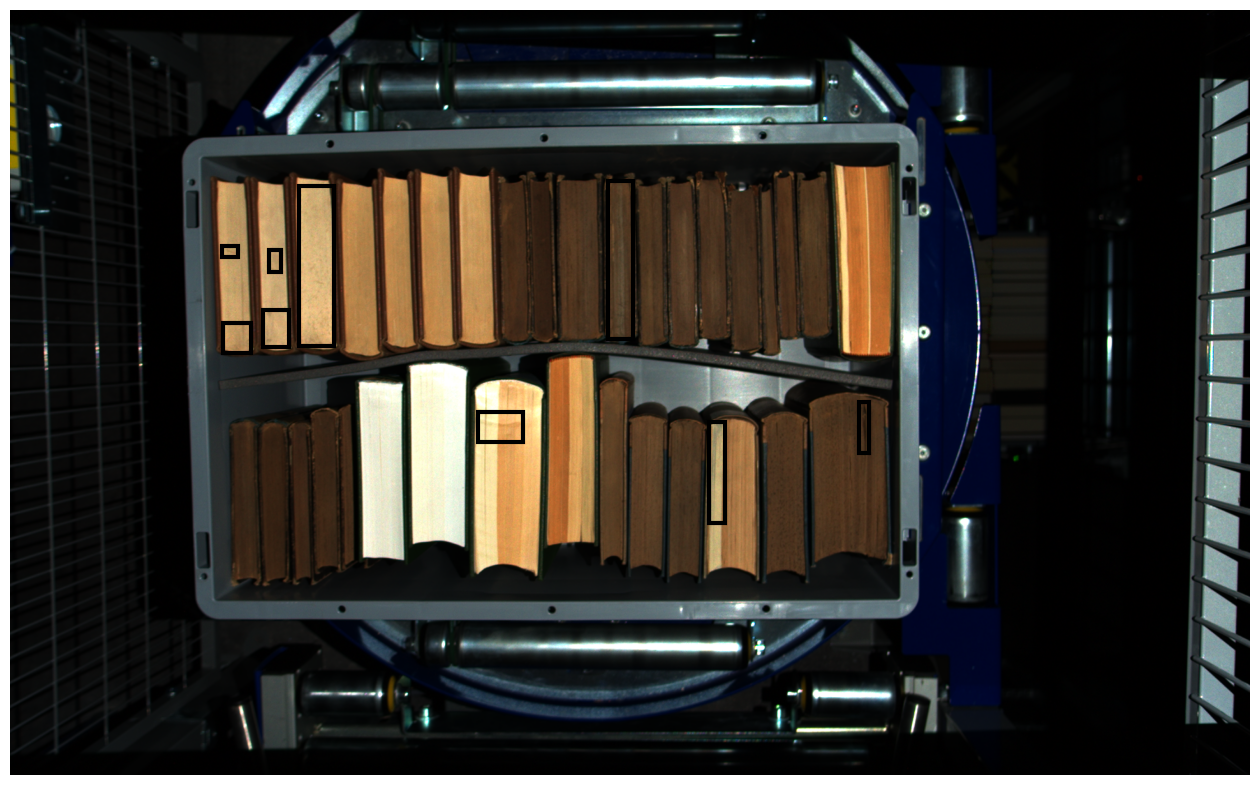

{'scores': tensor([0.5147, 0.5150, 0.5093, 0.5072, 0.5039, 0.5036], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 932.9326,  678.7148, 1061.2709,  719.6025],
        [ 895.1359,  399.5757, 1057.3552,  447.8128],
        [ 887.8565,  590.4000, 1016.8412,  627.1846],
        [ 857.5188,  525.3656, 1010.0985,  565.9271],
        [1081.8405,  735.9771, 1179.0302,  780.9127],
        [1057.4618,  698.5078, 1150.1512,  742.0090]], device='cuda:0')}
{'Schmutz': 6}
{'Schmutz': 15, 'Schimmel': 2, 'Wasser': 1}


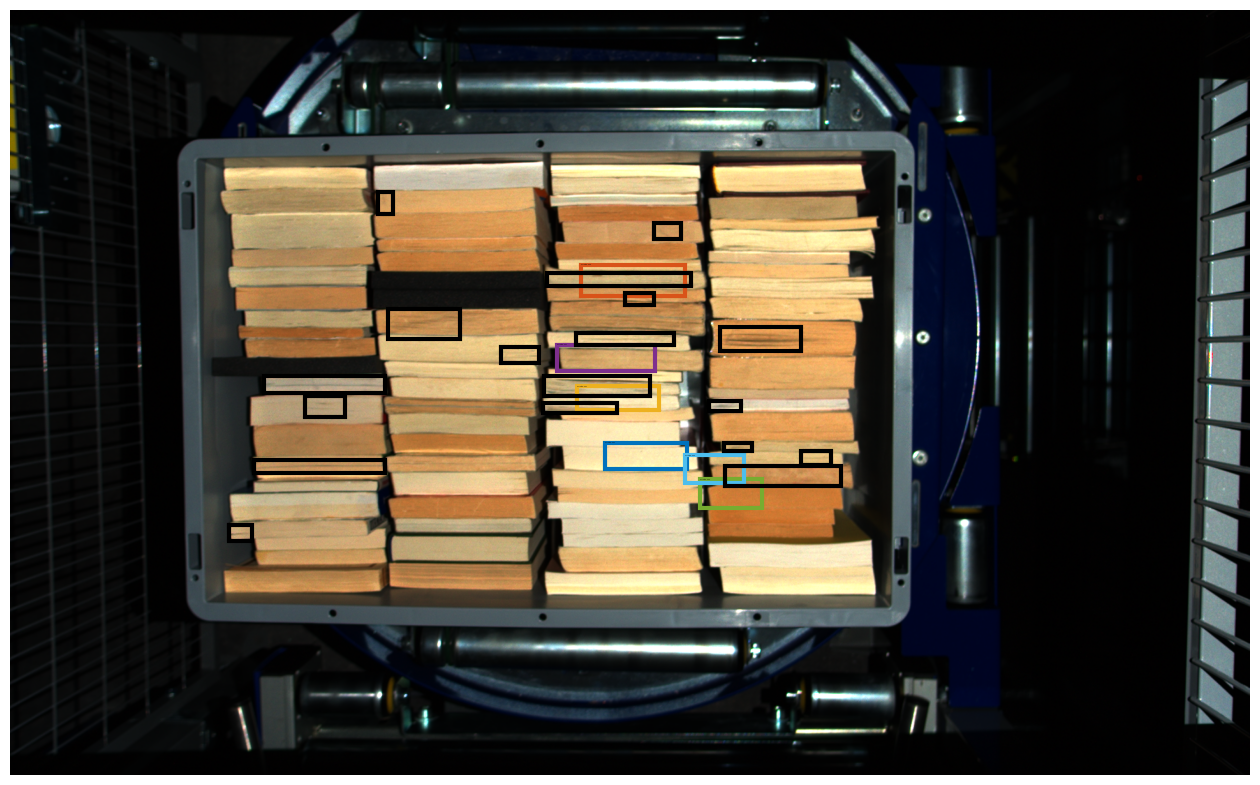

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{}


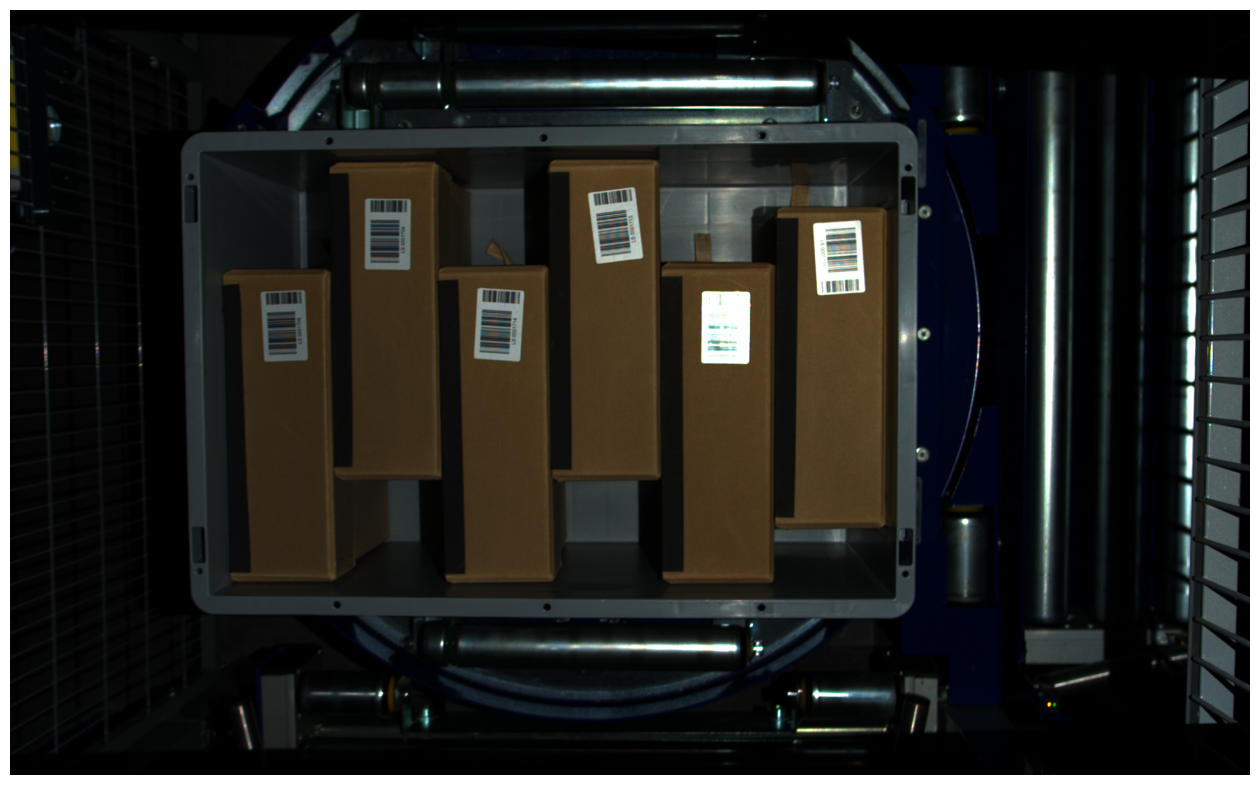

{'scores': tensor([0.5045, 0.5020, 0.5006, 0.5080, 0.5172, 0.5053, 0.5043, 0.5117],
       device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 937.4724,  682.3499, 1071.1570,  721.0926],
        [ 910.5040,  596.0788, 1050.0436,  632.2687],
        [ 896.0679,  668.4345, 1060.2808,  708.6512],
        [ 953.8952,  505.0365, 1059.0863,  544.0009],
        [ 861.3405,  522.6273,  992.4732,  561.5252],
        [1067.8766,  610.0753, 1148.0851,  646.0786],
        [1093.8469,  801.2570, 1183.8499,  843.2071],
        [ 958.6562,  825.3179, 1081.7458,  869.7990]], device='cuda:0')}
{'Schmutz': 8}
{'Schmutz': 18, 'Schäden': 2, 'Sonstiges': 1}


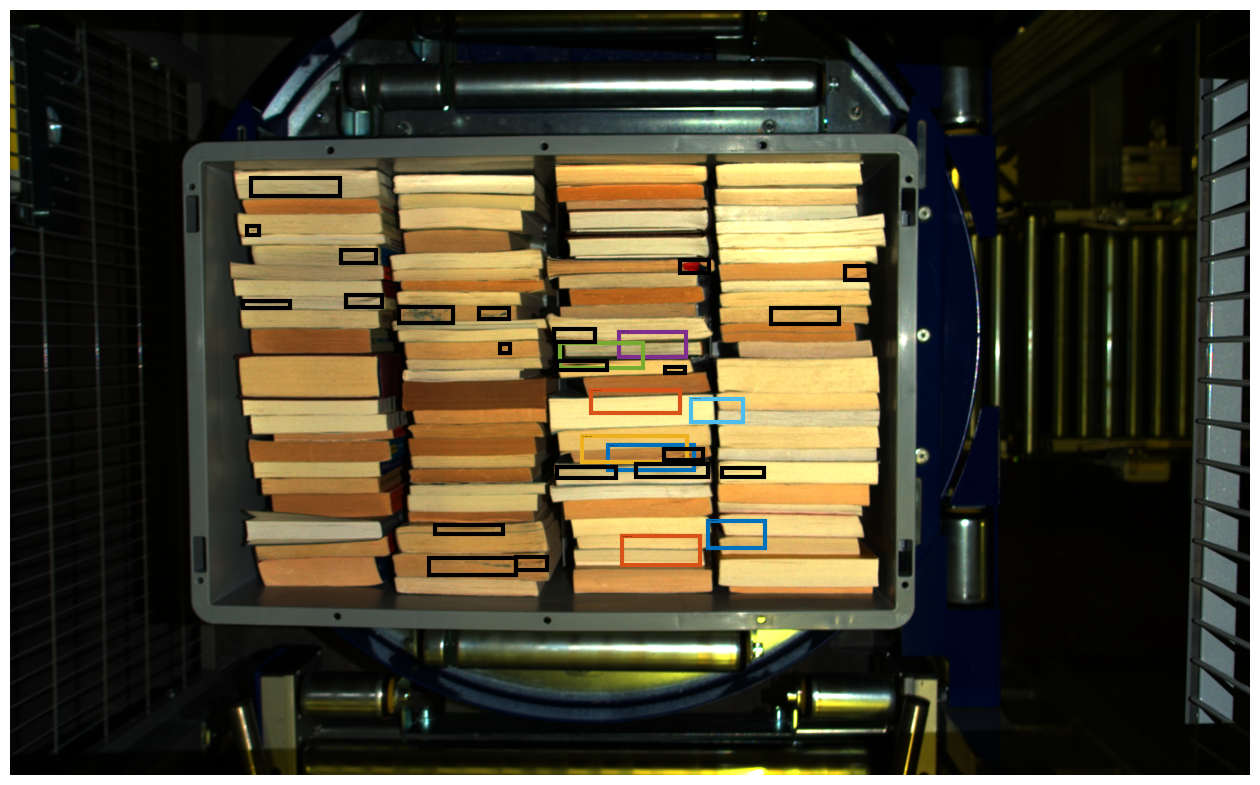

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{'Sonstiges': 12, 'Wasser': 1, 'Schmutz': 4}


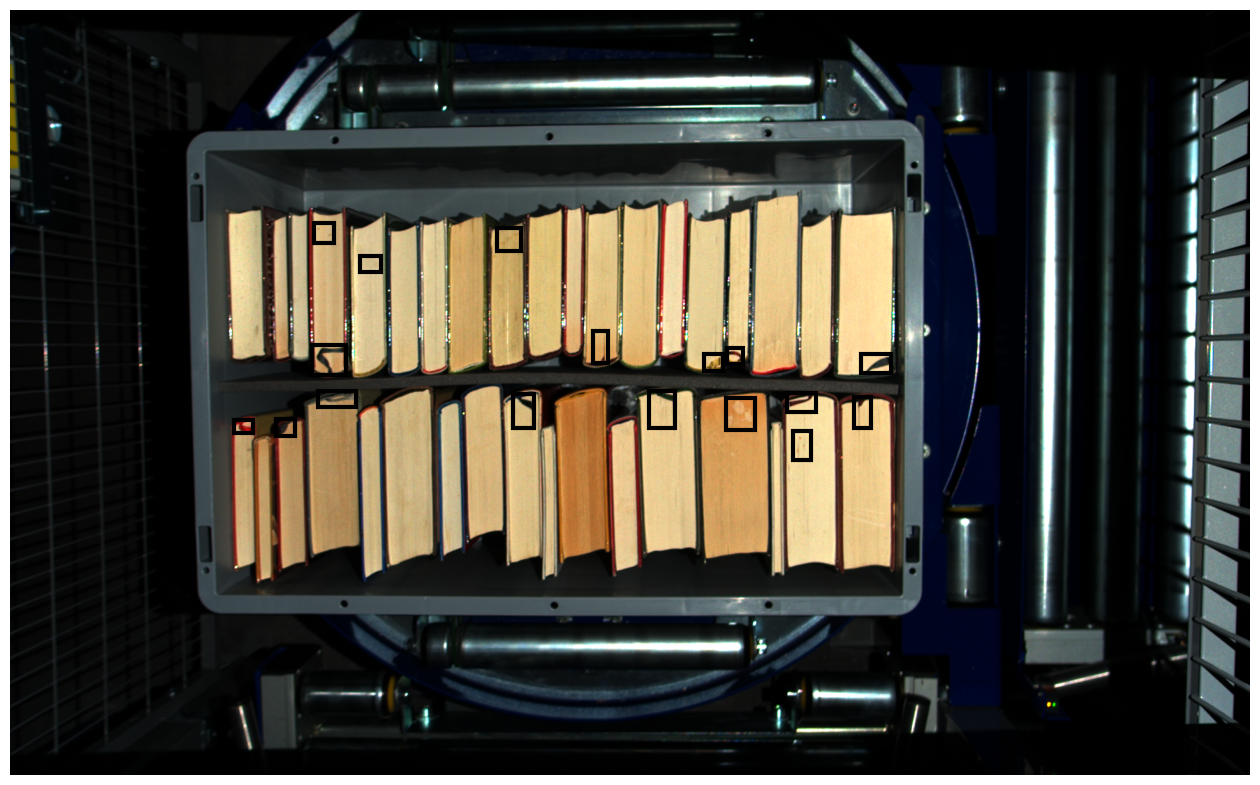

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{'Schmutz': 4, 'Sonstiges': 2}


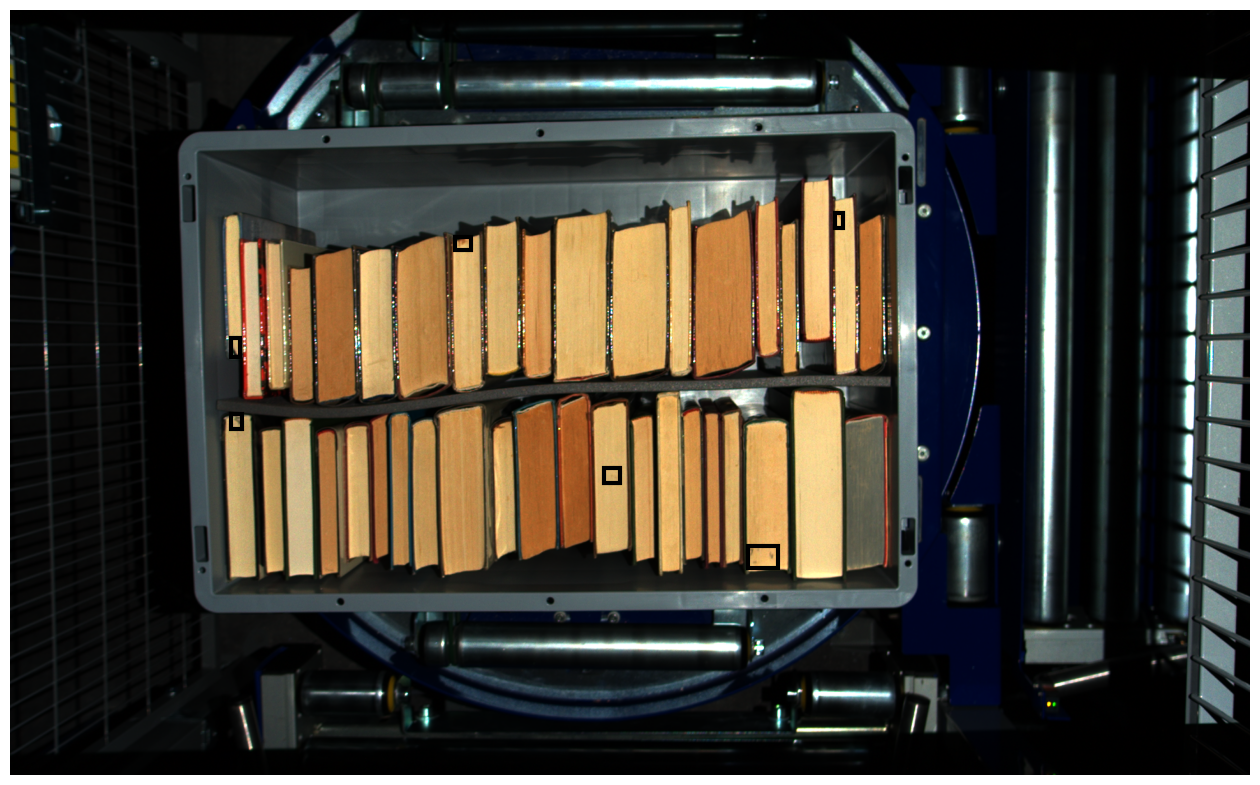

In [6]:
# Visualize
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.5)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)

    def save_predicted():
        # TODO output der boxen im coco format um nach dem annotieren direkt das ganze im trainingsdatensatz abspeichern zu können
        pass 

## Export predictions of new images

In [23]:
pixel_values, target = val_dataset[0]
pixel_values = pixel_values.unsqueeze(0).to(device)

print(pixel_values.shape)

torch.Size([1, 3, 800, 1296])


In [12]:
def writeJson(jsonObject, filename):
    if filename.split(".")[-1] != "json":
        filename = f"{filename}.json"
    with open(filename, "w") as g:
        g.write(jsonObject)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_new_images = "../new_images/"
path_predictions = "../predicted_images"
input_file = "coco_new.json"
pred_coco_filename = "coco_predictions.json"
threshold_postprocessing = 0.5 # zu 50% sicher ist sich das modell, dass dies ein schaden ist

list_paths = [os.path.join(path_new_images, filename) for filename in os.listdir(path_new_images) if
                            filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]


processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

new_dataset = CocoDetection(img_folder=path_new_images, processor=processor, image_name=input_file)

print("Number of training examples:", len(new_dataset))

# Copy json if not in folder else create
pred_path = os.path.join(path_predictions, pred_coco_filename)

with open(os.path.join(path_new_images, input_file), "r") as f:
    coco_tmp = json.load(f)

if os.path.exists(pred_path):
    with open(pred_path, "r") as f:
        coco_predict = json.load(f)
    
    # append image infos
    for x in coco_tmp["images"]:
        tmp = True
        for z in coco_predict["images"]:
            if x["id"] == z["id"]:
                tmp = False
        if tmp:
            coco_predict["images"].append(x)

else:
    coco_predict = copy.copy(coco_tmp)

# start id for annotations
if coco_predict["annotations"] == []:
    id_count = 0
else:
    id_count = coco_predict["annotations"][-1]["id"] + 1

for z in range(len(list_paths)):
    pixel_values, target = new_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)
    
    # postprocess model outputs
    width, height = target["size"]
    p_postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=threshold_postprocessing)
    # darf nur einmal durchlaufen, sonst gibts doppelte einträge
    for d in range(len(p_postprocessed_outputs[0]["labels"])):
        # Write predictions into annotations from pred_coco_filename
        # boxes == [xmin, ymin, xmax, ymax]
        box = p_postprocessed_outputs[0]["boxes"][d].tolist()
        dict_new_pred = {"id":id_count, 
                         "image_id":torch.Tensor.item(target["image_id"][0]), 
                         "category_id":int(p_postprocessed_outputs[0]["labels"][d]),
                         "segmentation":[], 
                         "bbox":p_postprocessed_outputs[0]["boxes"][d].tolist(), 
                         "ignore":0, 
                         "iscrowd":0, 
                         "area":((box[2]-box[0])*(box[3]-box[1]))}
        coco_predict["annotations"].append(dict_new_pred)
        id_count += 1

    for i in range(len(coco_tmp["images"])):
        if coco_tmp["images"][i]["id"] == torch.Tensor.item(target["image_id"][0]):
            del coco_tmp["images"][i]
    # move image to new location
    shutil.move(list_paths[z], os.path.join(path_predictions, list_paths[z].split("/")[-1]))



writeJson(json.dumps(coco_tmp, indent=4), os.path.join(path_new_images, input_file))
writeJson(json.dumps(coco_predict, indent=4), pred_path)
    

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 1
0
